Mandato con lr piu' grande sulla selection str perche 1e-4 era troppo piccola e non si muoveva di niente

In [2]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
import random

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R01CS", "R02N", "R02F", "R02S", "R02SF"]
# round_ids = ["ARN", "R01", "R01CS", "R02N"]
# round_ids = ["ARN", "R01", "R02N", "R02F"]


dtype = torch.float32

In [6]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id, device=torch.device("cpu"))
    sequences.append(s)
    print(f"finished {round_id}")

finished ARN
finished R01
finished R01CS
finished R02N
finished R02F
finished R02S
finished R02SF


In [7]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=torch.device("cpu")) for seq in sequences]

In [8]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [9]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/callback.py'>

In [67]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")
tr.add_node(0, name = "R02F")

picked_round_idx = [0, 1, 3, 4]

mode_names = ["NA, NW", "FA, NW"]

selected_modes = torch.BoolTensor(
    [
     [1, 0],
     [1, 0],
     [0, 1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == len(picked_round_idx) - 1
n_rounds = n_selection_rounds + 1

In [68]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype)
Ns0 = energy_models.IndepSites(k)

h_norm = torch.randn(L, q, dtype=dtype)
# J_norm = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)
potts_norm = energy_models.IndepSites(h_norm)

h_fast = torch.randn(L, q, dtype=dtype)
# J_fast = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)
potts_fast = energy_models.IndepSites(h_fast)

# unbound_mode = energy_models.ConstantEnergy(-10.0, learnable=False)

ps = selex_distribution.MultiModeDistribution(potts_norm, potts_fast, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [69]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")

In [70]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=device) 
                for id in picked_round_idx]

In [71]:
n_chains = 10**4

chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [72]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [90]:
model_device = model.to(device)
chains_device = chains.to(device)
total_reads_device = total_reads.to(device)
log_weights_device = log_weights.to(device)

In [91]:
n_sweeps = 10
target_pearson = 1
max_epochs = 2000
lr = 1e-2

training.train(model_device, data_loaders, total_reads_device, chains_device, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights_device)

 0.00%[                                                                                                       …

In [92]:
model = model_device.to(torch.device('cpu'))
chains = chains_device.to(torch.device('cpu'))
total_reads = total_reads_device.to(torch.device('cpu'))
log_weights = log_weights_device.to(torch.device('cpu'))

del model_device, chains_device, total_reads_device, log_weights_device
torch.cuda.empty_cache()

import gc
gc.collect()

51068

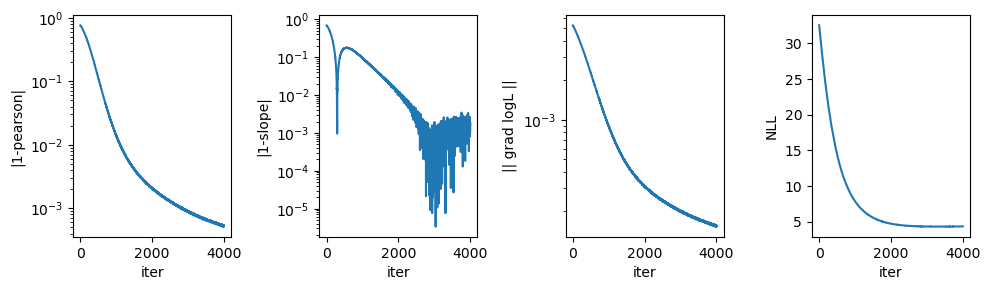

In [101]:
callbacks[0].plot();

In [94]:
X = sequences_oh[1]

In [95]:
logps_modes = []
for i in range(len(model.selection.modes)):
    logps = model.selection.modes[i].compute_energy(X).detach()
    logps_modes.append(logps)
    print(f"finished {i+1}-th mode")

finished 1-th mode
finished 2-th mode


In [96]:
mode_labels = ['norm A, norm W', 'fast A, norm W']

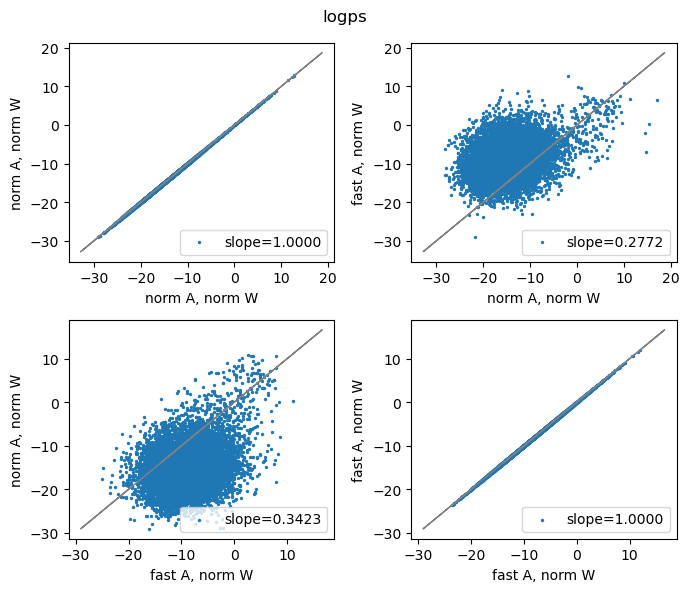

In [100]:
fig, axes = plt.subplots(n_modes, n_modes, 
                         # sharex=True, sharey=True, 
                         figsize=(7,6)
                        )
N = 10**4

for i in range(n_modes):
    for j in range(n_modes):
        ax = axes[i,j]
        x = logps_modes[i]
        y = logps_modes[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        sl = utils.compute_slope(x, y)
        ax.scatter(x[idx], y[idx], s=2, label=f'slope={sl:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(mode_labels[i])
        ax.set_ylabel(mode_labels[j])
fig.suptitle('logps')
fig.tight_layout()

In [98]:
potts_norm_zerosum = potts_norm.set_zerosum_gauge()
potts_fast_zerosum = potts_fast.set_zerosum_gauge()

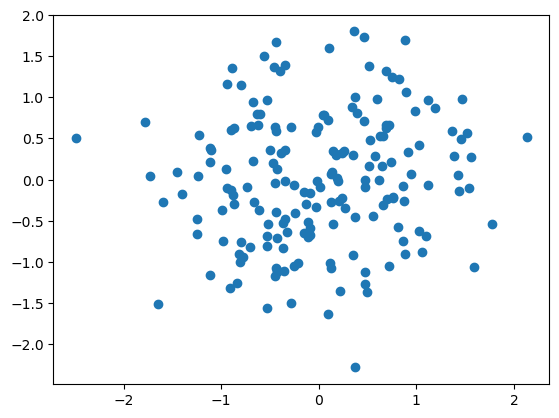

In [99]:
plt.scatter(potts_fast_zerosum.h.detach(), potts_norm_zerosum.h.detach())